# REQUIREMENTS

In [1]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

# veervohra
# rzoj3miTfgD$

Loading library list...
Done


# DATA COLLECTION

In [2]:
sp500_data = conn.raw_sql("""
SELECT
    caldt AS date,
    sprtrn AS daily_return -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '1990-01-01'
ORDER BY
    caldt;
""")
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

In [3]:
risk_free_data = conn.raw_sql('''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '1990-01-01'
''')
risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

### COMPANY DATA

In [4]:
# retrieves ID (permno) and earliest recorded name for each company in CRSP database
# 37,776 companies available
comps = conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')

comps[comps['company_name'] == 'NVIDIA CORP']

,permno,company_name
8,86580,NVIDIA CORP


In [5]:
# Using NVIDIA as example to figure out the algorithm.

link = conn.raw_sql('''
SELECT *
FROM crsp.ccmxpf_linktable
WHERE lpermno = 86580;
''')

link

,gvkey,linkprim,liid,linktype,lpermno,lpermco,usedflag,linkdt,linkenddt
0,117768,P,01,LU,86580.0,16382.0,1.0,1999-01-22,None


In [6]:
nvidia_gvkey = link['gvkey'][0]
nvidia_permno = str(link['lpermno'][0])

In [7]:
nvidia_comp_data = conn.raw_sql(f'''
SELECT
    f.datadate AS date,
    f.atq AS total_assets,  -- Total Assets
    f.chq AS cash_holdings,  -- Cash and Short-Term Investments
    f.rdq AS reporting_date -- Date of which information was reported
FROM
    comp.fundq f
WHERE
    gvkey = '{nvidia_gvkey}'
    AND f.datadate >= '1990-01-01'  -- Ensure data is after the link start date
''')

nvidia_comp_data['date'] = pd.to_datetime(nvidia_comp_data['date'])
nvidia_comp_data['reporting_date'] = pd.to_datetime(nvidia_comp_data['reporting_date'])
nvidia_comp_data['quarter_start'] = nvidia_comp_data['date'] - pd.offsets.QuarterBegin(n=2)
nvidia_comp_data['quarter_end'] = nvidia_comp_data['date']

nvidia_comp_data

# nvidia['date'] = nvidia['reporting_date'] # backtest logic

,date,total_assets,cash_holdings,reporting_date,quarter_start,quarter_end
0,1996-03-31,NaN,NaN,NaT,1995-12-01,1996-03-31
1,1996-06-30,NaN,NaN,NaT,1996-03-01,1996-06-30
2,1996-09-30,NaN,NaN,NaT,1996-06-01,1996-09-30
3,1996-12-31,5.525,NaN,NaT,1996-09-01,1996-12-31
4,1997-03-31,0.000,NaN,NaT,1996-12-01,1997-03-31
...,...,...,...,...,...,...
109,2023-07-31,49555.000,5783.0,2023-08-23,2023-03-01,2023-07-31
110,2023-10-31,54148.000,5519.0,2023-11-21,2023-06-01,2023-10-31
111,2024-01-31,65728.000,7280.0,2024-02-21,2023-09-01,2024-01-31
112,2024-04-30,77072.000,7587.0,2024-05-22,2023-12-01,2024-04-30


In [ ]:
# TODO: backfill financial data to make it monthly
# This will correct all the mistakes that follows this point
# REQUIREMENTS: data should be monthly and EOM

In [9]:
nvidia_stock_prcs = conn.raw_sql(f'''
SELECT
    date,
    prc AS stock_price,
    ret AS stock_return  -- Stock returns from CRSP
    -- prc * shrout AS market_cap  -- Market cap
FROM
    crsp.msf
WHERE
    permno = {nvidia_permno}
''')

nvidia_stock_prcs['date'] = pd.to_datetime(nvidia_stock_prcs['date'])

nvidia_stock_prcs

,date,stock_price,stock_return
0,1998-12-31,NaN,NaN
1,1999-01-29,19.00000,NaN
2,1999-02-26,21.93750,0.154605
3,1999-03-31,21.12500,-0.037037
4,1999-04-30,18.25000,-0.136095
...,...,...,...
296,2023-08-31,493.54999,0.056196
297,2023-09-29,434.98999,-0.118570
298,2023-10-31,407.79999,-0.062507
299,2023-11-30,467.70001,0.146886


In [10]:
nvidia = pd.merge(nvidia_comp_data, nvidia_stock_prcs, on='date', how='inner')

In [11]:
def aggregate_quarterly(start_date, end_date, daily_data, column, agg_func):
    # Aggregates data within the given start_date and end_date range.
    mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
    return agg_func(daily_data.loc[mask, column])

nvidia['snp_quarterly_return'] = nvidia.apply(
    lambda row: aggregate_quarterly(row['quarter_start'], row['quarter_end'], sp500_data, 'daily_return', 
                                    lambda x: np.prod(1 + x) - 1), axis=1
)

nvidia['rf_quarterly_rate'] = nvidia.apply(
    lambda row: aggregate_quarterly(row['quarter_start'], row['quarter_end'], risk_free_data, 'daily_rf_rate', 
                                    np.mean), axis=1
)

# CALCULATIONS (CASH-HEDGING & RETURNS)

In [12]:
nvidia['cash_share_weight'] = (nvidia['cash_holdings'] / nvidia['total_assets'])
nvidia['quarterly_return'] = nvidia['stock_price'].pct_change(fill_method=None)

### $ b_{t}^{i} $ - return on cash between periods

In [13]:
# the paper calculates it in a pretty complicated method, we'll start like this

nvidia['cash_holdings_t_minus_1'] = nvidia['cash_holdings'].shift()
nvidia['b_it'] = ( nvidia['cash_holdings'] - nvidia['cash_holdings_t_minus_1'] ) / nvidia['cash_holdings_t_minus_1']

### $ e_{t}^{i} $ - cash hedged returns

In [14]:
# calculate the cash-hedged return (e_it)

nvidia['cash_hedged_return'] = (1 / (1 - nvidia['cash_share_weight'])) * (nvidia['quarterly_return'] - (nvidia['cash_share_weight']  * nvidia['b_it']))

nvidia = nvidia.dropna()

nvidia

,date,total_assets,cash_holdings,reporting_date,quarter_start,quarter_end,stock_price,stock_return,snp_quarterly_return,rf_quarterly_rate,cash_share_weight,quarterly_return,cash_holdings_t_minus_1,b_it,cash_hedged_return
24,2007-07-31,3036.267,914.745,2007-08-09,2007-03-01,2007-07-31,45.76000,0.107722,0.034436,0.000194,0.301273,0.391304,678.951,0.347292,0.410281
25,2007-10-31,3475.263,1056.702,2007-11-08,2007-06-01,2007-10-31,35.38000,-0.023731,0.012253,0.000174,0.304064,-0.226836,914.745,0.155188,-0.393747
26,2008-01-31,3747.671,508.869,2008-02-13,2007-09-01,2008-01-31,24.59000,-0.277190,-0.064751,0.000141,0.135783,-0.304975,1056.702,-0.518437,-0.271436
27,2008-04-30,3807.458,803.308,2008-05-08,2007-12-01,2008-04-30,20.55000,0.038403,-0.064512,0.000096,0.210983,-0.164294,508.869,0.578615,-0.362948
28,2008-07-31,3960.049,719.143,2008-08-12,2008-03-01,2008-07-31,11.44000,-0.388889,-0.047535,0.000080,0.181600,-0.443309,803.308,-0.104773,-0.518429
29,2008-10-31,3648.898,461.253,2008-11-06,2008-06-01,2008-10-31,8.76000,-0.182073,-0.308225,0.000064,0.126409,-0.234266,719.143,-0.358607,-0.216273
30,2009-04-30,3178.704,512.274,2009-05-07,2008-12-01,2009-04-30,11.48000,0.164300,-0.026145,0.000006,0.161158,0.310502,461.253,0.110614,0.348905
31,2009-07-31,3298.409,523.785,2009-08-06,2009-03-01,2009-07-31,12.93000,0.145261,0.343343,0.000006,0.158799,0.126307,512.274,0.022470,0.145909
32,2010-04-30,3803.030,447.262,2010-05-13,2009-12-01,2010-04-30,15.71000,-0.097126,0.083111,0.000002,0.117607,0.215004,523.785,-0.146096,0.263132
33,2011-01-31,4495.246,665.361,2011-02-16,2010-09-01,2011-01-31,23.92000,0.553247,0.225663,0.000008,0.148014,0.522597,447.262,0.487631,0.528672


# BETA CALCULATION

Seems like in some instances cash_hedged_returns is getting super over inflated. Ideally, that is what we want! But will need to make sure the raise in risk is also reflected.

Next steps:
* Calculate Beta for non-cash assets in NVIDIA
* Use above data to test returns in cash-hedged for NVIDIA over time (long-only) 
* (etc)

Calculating Stock Beta and Cash-Hedged Beta (PiT).

In [15]:
window = 4

def calculate_rolling_beta(stock_return, market_return, window):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

In [16]:

nvidia['nvidia_beta'] = calculate_rolling_beta(nvidia['quarterly_return'], nvidia['snp_quarterly_return'], window)
nvidia['google_beta'] = calculate_rolling_beta(nvidia['cash_hedged_return'], nvidia['snp_quarterly_return'], window)
nvidia['snp_beta'] = calculate_rolling_beta(nvidia['snp_quarterly_return'], nvidia['snp_quarterly_return'], window)

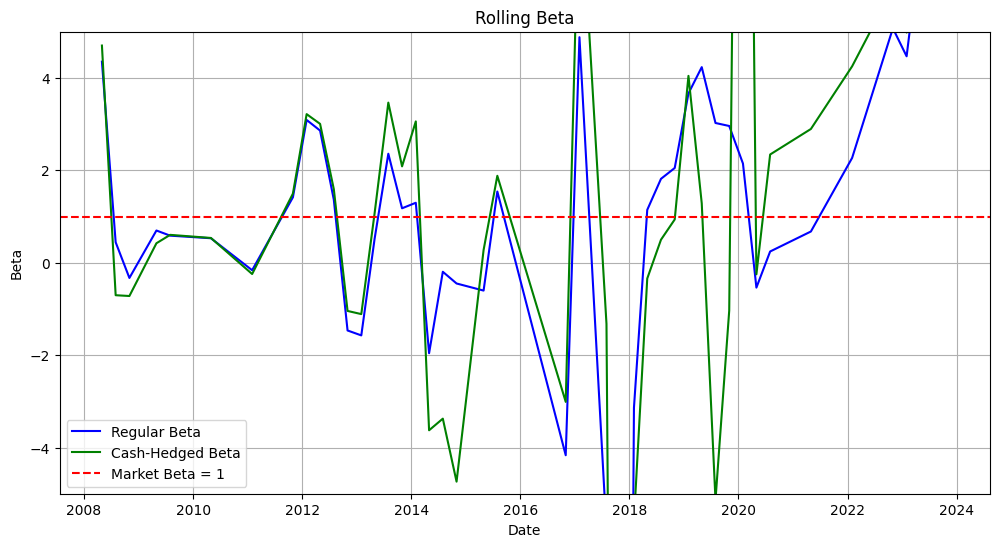

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(nvidia['date'], nvidia['nvidia_beta'], label='Regular Beta', color='blue')
plt.plot(nvidia['date'], nvidia['google_beta'], label='Cash-Hedged Beta', color='green')
plt.axhline(1, color='red', linestyle='--', label='Market Beta = 1')
plt.title('Rolling Beta')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.ylim(-5, 5)
plt.grid()
plt.show()


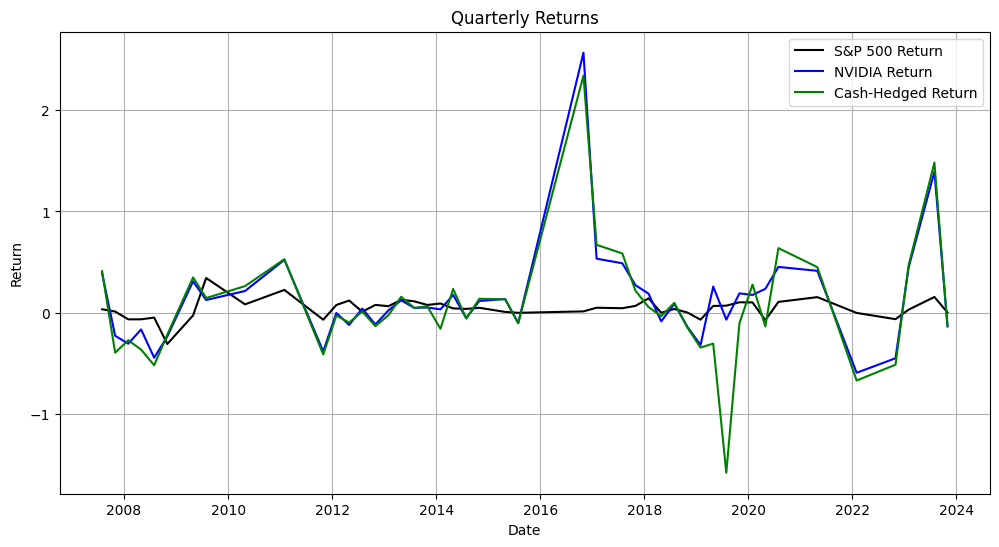

In [18]:

plt.figure(figsize=(12, 6))
plt.plot(nvidia['date'], nvidia['snp_quarterly_return'], label='S&P 500 Return', color='black')
plt.plot(nvidia['date'], nvidia['quarterly_return'], label='NVIDIA Return', color='blue')
plt.plot(nvidia['date'], nvidia['cash_hedged_return'], label='Cash-Hedged Return', color='green')
plt.title('Quarterly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

In [19]:
nvidia['snp_cum_return'] = (1 + nvidia['snp_quarterly_return']).cumprod() - 1
nvidia['nvidia_cum_return'] = (1 + nvidia['quarterly_return']).cumprod() - 1
nvidia['google_cum_return'] = (1 + nvidia['cash_hedged_return']).cumprod() - 1

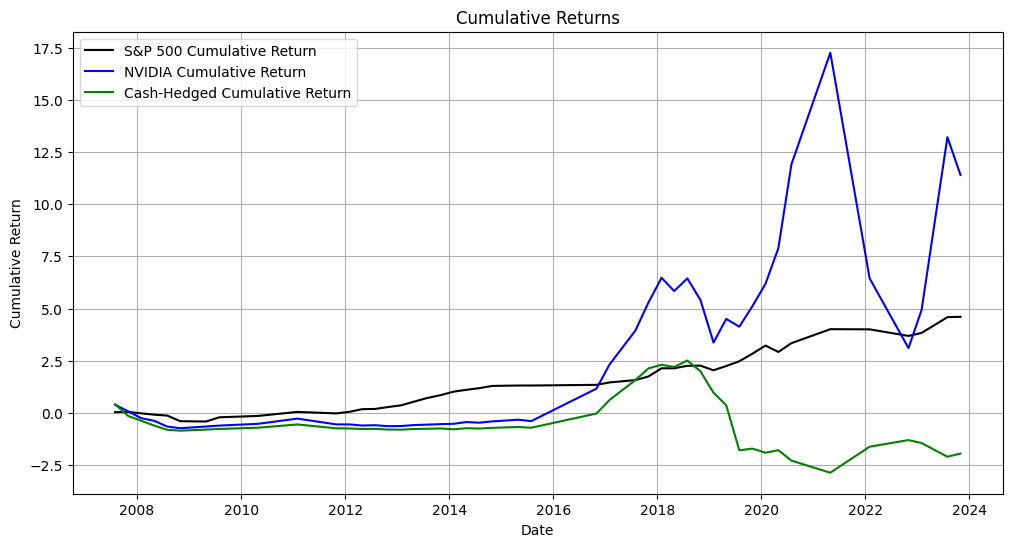

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(nvidia['date'], nvidia['snp_cum_return'], label='S&P 500 Cumulative Return', color='black')
plt.plot(nvidia['date'], nvidia['nvidia_cum_return'], label='NVIDIA Cumulative Return', color='blue')
plt.plot(nvidia['date'], nvidia['google_cum_return'], label='Cash-Hedged Cumulative Return', color='green')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()